In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
import os
import json

### Load in the data

In [8]:
df = pd.read_csv('data/data_random_split.csv')

In [9]:
df.head()

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,split
0,coronavirus,The Guardian,0,https://www.theguardian.com/world/2020/mar/26/...,US coronavirus stimulus checks: are you eligib...,2020-03-26,Lauren Aratani,Most taxpayers will get a check from the $ 2tn...,Most taxpayers will get a check from the $2tn ...,www.theguardian.com,left,IBgtqEHUEcjyMriR,train
1,healthcare,Washington Times,2,http://www.washingtontimes.com/news/2013/feb/1...,After Obamacare health exchange deadline passe...,2013-02-16,Tom Howell Jr.,The backbone of President Obama ’ s health car...,The backbone of President Obama’s health care ...,www.washingtontimes.com,right,LC3zdsbACLILzBhY,train
2,politics,National Review,2,https://www.nationalreview.com/2019/08/the-doj...,The DOJ Will Not Prosecute James Comey over Tr...,2019-08-03,"Andrew C. Mccarthy, John Mccormack, Michael Br...",Then-FBI Director James Comey testifying on Ca...,Then-FBI Director James Comey testifying on Ca...,www.nationalreview.com,right,W084H19Vniu1Z24f,train
3,media_bias,NPR Online News,1,https://www.npr.org/2018/08/27/642356784/fox-n...,Fox News Hasn't Always Shared Robert Driscoll'...,2018-08-27,David Folkenflik,Fox News Has n't Always Shared Robert Driscoll...,Fox News Hasn't Always Shared Robert Driscoll'...,www.npr.org,center,Lcvv69hlu4J5Foc3,train
4,trade,Bloomberg,1,https://www.bloomberg.com/news/articles/2019-0...,"Wilbur Ross Says U.S., China ‘Miles and Miles’...",2019-01-24,"Brendan Murray, Andrew Mayeda",LISTEN TO ARTICLE 2:15 SHARE THIS ARTICLE Shar...,LISTEN TO ARTICLE 2:15 SHARE THIS ARTICLE Shar...,www.bloomberg.com,center,ZW7MmqXMtiJgL6jY,train


In [10]:
df.columns

Index(['topic', 'source', 'bias', 'url', 'title', 'date', 'authors', 'content',
       'content_original', 'source_url', 'bias_text', 'ID', 'split'],
      dtype='object')

In [11]:
#check missing values in the dataset
df.isnull().sum()

topic                  0
source                 0
bias                   0
url                    0
title                  0
date                4039
authors             9262
content                0
content_original       0
source_url             0
bias_text              0
ID                     0
split                  0
dtype: int64

### EDA

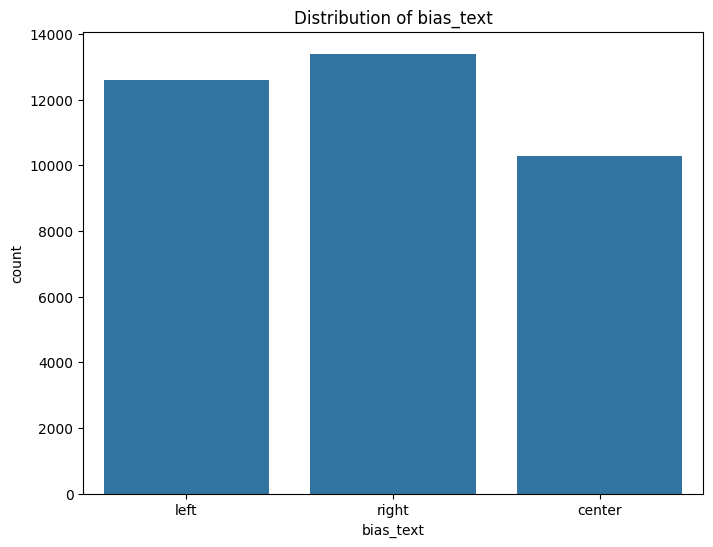

In [12]:
# plot the distribution of bias_text
plt.figure(figsize=(8, 6))
sns.countplot(x='bias_text', data=df)
plt.title('Distribution of bias_text')
plt.show()

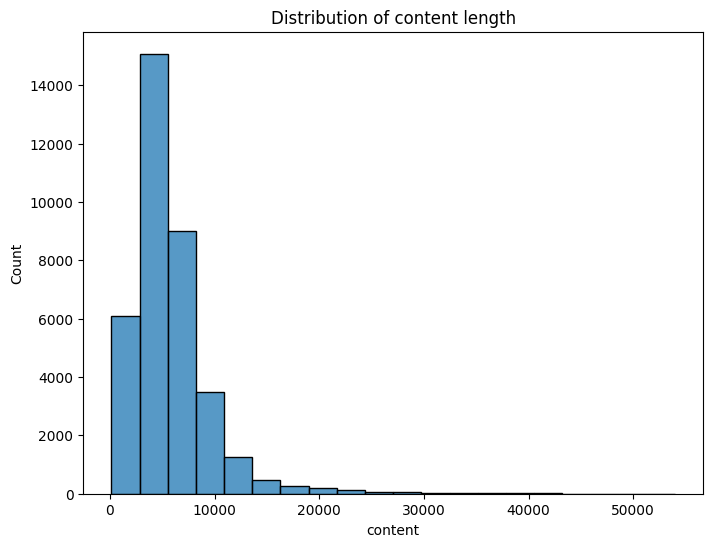

In [13]:
# plot the distribution of content length
plt.figure(figsize=(8, 6))
sns.histplot(df['content'].str.len(), bins=20)
plt.title('Distribution of content length')
plt.show()

### Word Clouds for Each Bias

In [4]:
# !pip install wordcloud
from wordcloud import WordCloud

biases = df['bias'].unique()
for bias in biases:
    text = " ".join(df[df['bias'] == bias]['content_original'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {bias}")
    plt.axis('off')
    plt.show()

NameError: name 'df' is not defined

### Text Preprocessing

In [14]:
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from tqdm import tqdm

def tokenize_and_tfidf(df, text_column='content', model_name="bert-base-uncased"):
    """
    Tokenizes text using a Transformer tokenizer and applies TF-IDF vectorization.

    Parameters:
    - df (pd.DataFrame): DataFrame containing a column with text data.
    - text_column (str): Column name that contains raw text.
    - model_name (str): Hugging Face model to use for tokenization.

    Returns:
    - tfidf_matrix (sparse matrix): TF-IDF transformed matrix of tokenized text.
    - feature_names (list): List of TF-IDF feature names (tokens).
    """

    # Enable progress bar
    tqdm.pandas()

    # Apply TF-IDF and remove stopwords with automatic tokenizer
    tfidf = TfidfVectorizer(stop_words='english', max_features=5000, min_df=5)
    tfidf_matrix = tfidf.fit_transform(df[text_column])

    return tfidf_matrix, tfidf.get_feature_names_out()

In [15]:
# Run Tokenization and TF-IDF
tfidf_matrix, feature_names = tokenize_and_tfidf(df, text_column='content')

# Check the shape of the matrix
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

# Display sample feature names (tokens)
print("Sample Tokens:", feature_names[:10])

TF-IDF Matrix Shape: (36274, 5000)
Sample Tokens: ['00' '000' '01' '02' '03' '04' '10' '100' '11' '12']


In [16]:
# convert the matrix to a pandas DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df.head()

,00,000,01,02,03,04,10,100,11,12,...,yesterday,york,young,younger,youth,youtube,zelensky,zero,zone,zuckerberg
0,0.0,0.146491,0.0,0.0,0.0,0.0,0.019656,0.024502,0.0,0.02425,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,...,0.0,0.012192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.040725,0.000000,0.0,0.00000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
# remove numeric tokens in tfidf_df
def remove_numeric_tokens(text):
    return " ".join([word for word in text.split() if not re.fullmatch(r"\d+", word)])

# Apply the function to the 'content' column
df['clean_text'] = df['content'].apply(remove_numeric_tokens)

# Run Tokenization and TF-IDF
tfidf_matrix, feature_names = tokenize_and_tfidf(df, text_column='clean_text')

# Check the shape of the matrix
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

TF-IDF Matrix Shape: (36274, 5000)


In [18]:
tfidf_df = tfidf_matrix
tfidf_df =pd.DataFrame(tfidf_df.toarray(), columns=feature_names)
tfidf_df.head()

,00,000,01,02,03,04,10,100,11,12,...,yesterday,york,young,younger,youth,youtube,zelensky,zero,zone,zuckerberg
0,0.0,0.14958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.01219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Top N frequent words for each bias

In [45]:
# For each bias, get the top 10 words by average TF-IDF score
for bias in biases:
    mean_tfidf = tfidf_df[df['bias'] == bias].mean().drop('bias')
    top_words = mean_tfidf.sort_values(ascending=False).head(10)
    print(f"Top words for bias '{bias}':")
    print(top_words, "\n")

Top words for bias '0':
trump        0.062361
said         0.053437
obama        0.034122
president    0.032046
clinton      0.027243
people       0.027083
house        0.026968
mr           0.025794
campaign     0.023179
new          0.022886
dtype: float64 

Top words for bias '1':
trump        0.080715
said         0.059386
president    0.036051
mr           0.029018
house        0.028747
says         0.028442
people       0.024564
democrats    0.022991
new          0.022070
state        0.021952
dtype: float64 

Top words for bias '2':
trump        0.058360
said         0.052559
mr           0.045084
president    0.036954
obama        0.034182
house        0.025885
clinton      0.023884
people       0.023549
percent      0.023342
state        0.021616
dtype: float64 



## Model Training

### Tree-Based Model

In [19]:
df["split"].value_counts()

split
train    27978
valid     6996
test      1300
Name: count, dtype: int64

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Convert TF-IDF matrix to array
X = tfidf_matrix.toarray()
y = df['bias']

X_train = X[df["split"] == "train"]
y_train = y[df["split"] == "train"]
X_val = X[df["split"] == "valid"]
y_val = y[df["split"] == "valid"]
X_test = X[df["split"] == "test"]
y_test = y[df["split"] == "test"]

In [21]:
print("Training Set Shape:", X_train.shape, y_train.shape)

Training Set Shape: (27978, 5000) (27978,)


In [36]:
# Train Random Forest model
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# Predict on test set
y_pred = rf_clf.predict(X_val)

# Evaluate model performance
accuracy = accuracy_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, target_names=['left', 'center', 'right'])

print("Random Forest Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Random Forest Accuracy: 0.6972555746140652
Classification Report:
               precision    recall  f1-score   support

        left       0.76      0.63      0.69      2438
      center       0.83      0.57      0.67      1998
       right       0.61      0.87      0.72      2560

    accuracy                           0.70      6996
   macro avg       0.74      0.69      0.69      6996
weighted avg       0.73      0.70      0.69      6996



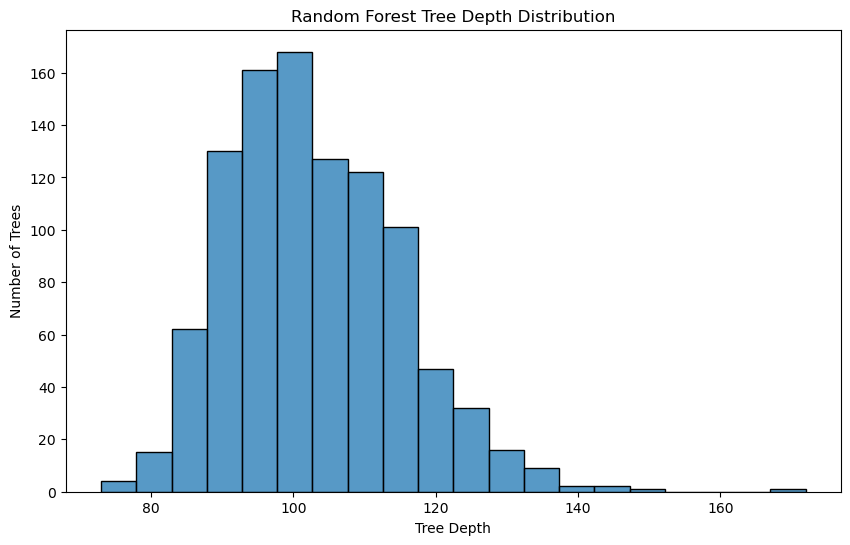

In [42]:
# Visualize the depth of the trees
plt.figure(figsize=(10, 6))
sns.histplot([estimator.tree_.max_depth for estimator in rf_clf.estimators_], bins=20)
plt.title('Random Forest Tree Depth Distribution')
plt.xlabel('Tree Depth')
plt.ylabel('Number of Trees')
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter for RandomizedSearch
param_grid = {
    'n_estimators': [100, 300, 500, 1000],  # Number of trees
    'max_depth': [30, 50, 100, 125, 150],     # Depth of trees
    'min_samples_split': [2, 5, 10]   # Minimum samples per split
}

# Run RandomizedSearch
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid, cv=3, verbose=2, n_iter=15)
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Train final model with best params
best_rf = random_search.best_estimator_
y_pred_best = best_rf.predict(X_val)

# Evaluate tuned model
print("Tuned Random Forest Accuracy:", accuracy_score(y_val, y_pred_best))

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END max_depth=125, min_samples_split=10, n_estimators=100; total time=   4.0s
[CV] END max_depth=125, min_samples_split=10, n_estimators=100; total time=   3.6s
[CV] END max_depth=125, min_samples_split=10, n_estimators=100; total time=   3.7s
[CV] END max_depth=125, min_samples_split=2, n_estimators=1000; total time=  36.9s
[CV] END max_depth=125, min_samples_split=2, n_estimators=1000; total time=  35.0s
[CV] END max_depth=125, min_samples_split=2, n_estimators=1000; total time=  35.6s
[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   3.0s
[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   3.0s
[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   3.1s
[CV] END max_depth=30, min_samples_split=5, n_estimators=300; total time=   8.9s
[CV] END max_depth=30, min_samples_split=5, n_estimators=300; total time=   8.9s
[CV] END max_depth=30, min_sample

In [38]:
print(classification_report(y_val, y_pred_best, target_names=['left', 'center', 'right']))

              precision    recall  f1-score   support

        left       0.77      0.59      0.67      2438
      center       0.85      0.55      0.67      1998
       right       0.59      0.88      0.71      2560

    accuracy                           0.69      6996
   macro avg       0.74      0.68      0.68      6996
weighted avg       0.73      0.69      0.68      6996



### PCA

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Initialize PCA with 2 components
pca = PCA(n_components=6999)
X_pca = pca.fit_transform(X)    # Fit and transform the data


# Plot explained variance to find the best n_components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()


In [ ]:
# Apply PCA with optimal components
pca = PCA(n_components=5000)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# #save pca results
# np.save('X_train_pca.npy', X_train_pca)
# np.save('X_test_pca.npy', X_test_pca)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train Random Forest on PCA-reduced features
rf_clf_pca = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf_clf_pca.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred_pca = rf_clf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
classification_report_pca = classification_report(y_test, y_pred_pca, target_names=['left', 'center', 'right'])

print("Random Forest Accuracy after PCA:", accuracy_pca)
print("Classification Report:\n", classification_report_pca)

Random Forest Accuracy after PCA: 0.4642524297696711
Classification Report:
               precision    recall  f1-score   support

        left       0.47      0.47      0.47      2629
      center       0.59      0.13      0.21      2103
       right       0.45      0.71      0.55      2779

    accuracy                           0.46      7511
   macro avg       0.50      0.44      0.41      7511
weighted avg       0.50      0.46      0.43      7511



### Model 2: Logistic Regression

In [22]:
# # load in the pca results
# X_train_pca = np.load('X_train_pca.npy')
# X_test_pca = np.load('X_test_pca.npy')

y = df['bias']

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from collections import Counter

In [24]:
y = df['bias']
Counter(y)

Counter({2: 13399, 0: 12590, 1: 10285})

In [25]:
# a baseline logistic regression model
baseline_clf = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
baseline_clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

In [26]:
y_pred_baseline = baseline_clf.predict(X_val)

In [27]:
# baseline logreg evaluation
print(classification_report(y_val, y_pred_baseline, target_names=['left', 'center', 'right']))

              precision    recall  f1-score   support

        left       0.70      0.67      0.69      2438
      center       0.70      0.66      0.68      1998
       right       0.67      0.72      0.69      2560

    accuracy                           0.69      6996
   macro avg       0.69      0.68      0.69      6996
weighted avg       0.69      0.69      0.69      6996



In [ ]:
# Logistic Regression and hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# random search for best hyperparameters
param_rand = {
    'C': [0.1, 100, 1, 10, 0.5],
    'penalty':('l1', 'l2')
}

rand_search = RandomizedSearchCV(LogisticRegression(random_state=42, solver="saga", max_iter=1000), param_rand,cv=3, verbose=2, n_iter=10, n_jobs=-1)
rand_search.fit(X_train, y_train)

print("Best Parameters from Random Search:", rand_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ..................................C=0.1, penalty=l2; total time=  55.4s
[CV] END ..................................C=0.1, penalty=l2; total time=  57.8s
[CV] END ..................................C=0.1, penalty=l2; total time=  57.8s
[CV] END ..................................C=0.1, penalty=l1; total time= 1.5min
[CV] END ..................................C=0.1, penalty=l1; total time= 2.6min
[CV] END ..................................C=0.1, penalty=l1; total time= 2.6min
[CV] END ..................................C=100, penalty=l2; total time=13.8min
[CV] END ..................................C=100, penalty=l2; total time=14.0min
[CV] END ..................................C=100, penalty=l2; total time=14.4min
[CV] END ....................................C=1, penalty=l2; total time= 1.2min
[CV] END ....................................C=1, penalty=l2; total time= 1.2min
[CV] END ....................................C=1

In [ ]:
# evalue the tuned model on the test set
best_logreg = rand_search.best_estimator_
y_pred_logreg = best_logreg.predict(X_val)

In [ ]:
# logreg evaluation
print(classification_report(y_val, y_pred_logreg, target_names=['left', 'center', 'right']))

              precision    recall  f1-score   support

        left       0.70      0.68      0.69      2629
      center       0.68      0.64      0.66      2103
       right       0.68      0.74      0.71      2779

    accuracy                           0.69      7511
   macro avg       0.69      0.69      0.69      7511
weighted avg       0.69      0.69      0.69      7511



In [ ]:
# logreg feature coefficients
best_logreg.coef_

array([[ 0.41779453, -0.42403149,  2.37738776, ...,  0.5449914 ,
         0.83225255, -0.05561032],
       [ 0.4437864 ,  0.20323244, -0.93818261, ..., -0.45367654,
        -0.06642648, -0.2638207 ],
       [-0.86158093,  0.22079905, -1.43920515, ..., -0.09131485,
        -0.76582607,  0.31943102]])

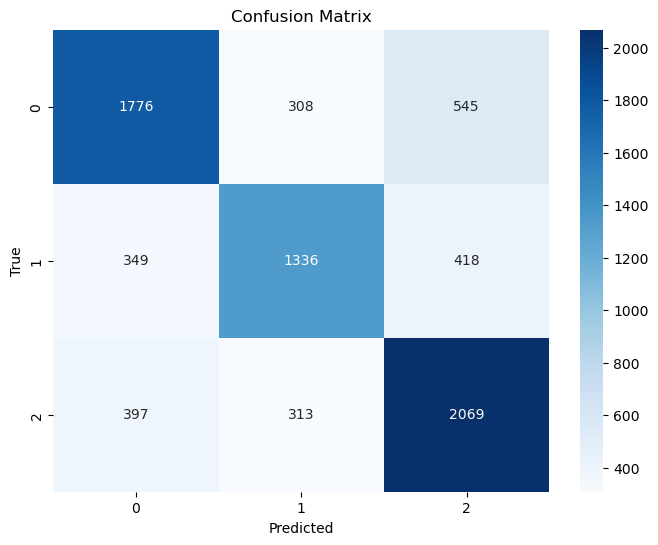

In [ ]:
# confusion matrix for logreg
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=biases, yticklabels=biases)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# feature importance for the best logreg model
coef = best_logreg.coef_[0]
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': coef})
top_features = feature_importance.sort_values(by='importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.title('Top 10 Features for Logistic Regression')
plt.show()